In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import random
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

ANALYSIS animals_data

In [ ]:
dataset_path = "./data/vision/raw-img"

In [5]:
classes = os.listdir(dataset_path)
print(f"Classes: {classes}")

The code translates image class names from Italian to English, counts the number of images in each category, and outputs a dataset summary.

In [9]:
# Define translation mapping
translation_map = {
    "cane": "dog",
    "cavallo": "horse",
    "elefante": "elephant",
    "farfalla": "butterfly",
    "gallina": "chicken",
    "gatto": "cat",
    "mucca": "cow",
    "pecora": "sheep",
    "ragno": "spider",
    "scoiattolo": "squirrel"
}

# Get class names and translate them
classes = os.listdir(dataset_path)
translated_classes = {cls: translation_map[cls] for cls in classes}

# Count the number of images in each class
class_counts = {translated_classes[cls]: len(os.listdir(os.path.join(dataset_path, cls))) for cls in classes}

# Print dataset summary
print(f"Total classes: {len(classes)}")
print(f"Total images: {sum(class_counts.values())}")

Total classes: 10
Total images: 26179


Class: dog, Number of images: 4863
Class: horse, Number of images: 2623
Class: elephant, Number of images: 1446
Class: butterfly, Number of images: 2112
Class: chicken, Number of images: 3098
Class: cat, Number of images: 1668
Class: cow, Number of images: 1866
Class: sheep, Number of images: 1820
Class: spider, Number of images: 4821
Class: squirrel, Number of images: 1862


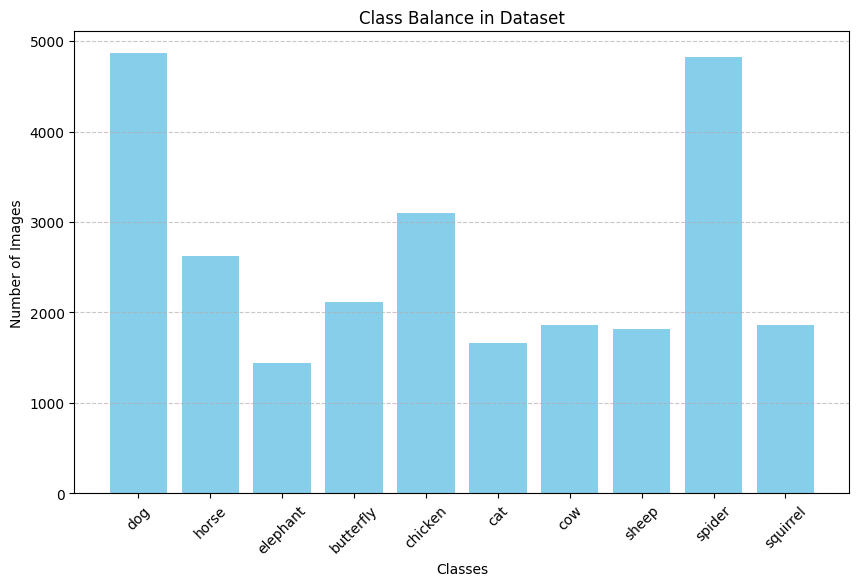

In [5]:
# Count the number of images in each class
class_counts = {translation_map[cls]: len(os.listdir(os.path.join(dataset_path, cls))) for cls in classes}

# Print the number of images per class
for cls, count in class_counts.items():
    print(f"Class: {cls}, Number of images: {count}")

# Visualize class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Class Balance in Dataset")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

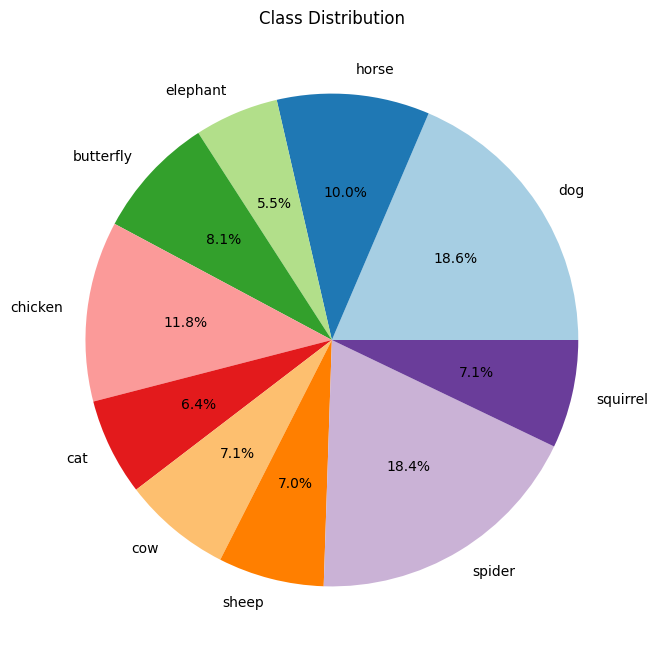

In [6]:
# Pie chart of class distribution
plt.figure(figsize=(8, 8))
plt.pie(class_counts.values(), labels=class_counts.keys(), autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.title("Class Distribution")
plt.show()

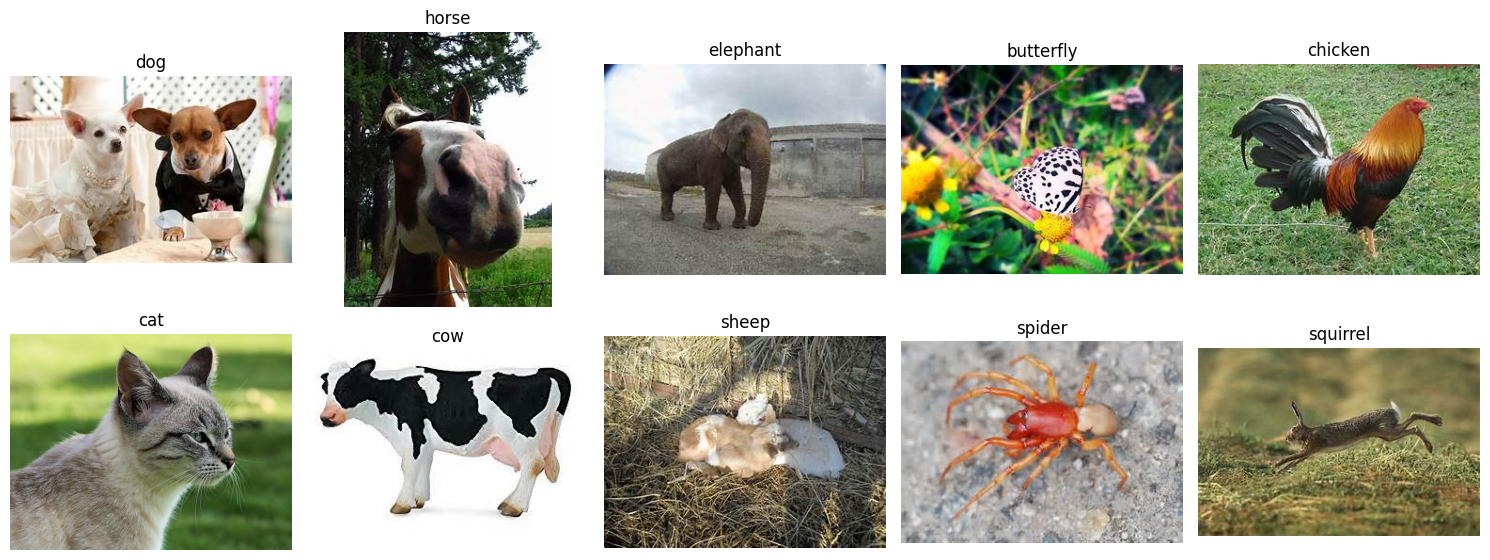

In [10]:
# Display random sample images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
axes = axes.ravel()

for i, cls in enumerate(classes[:10]):  # Take first 10 classes
    class_path = os.path.join(dataset_path, cls)
    img_name = random.choice(os.listdir(class_path))  # Random image
    img_path = os.path.join(class_path, img_name)
    
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].set_title(translation_map[cls])
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [11]:
# Check image sizes for a subset (500 random images)
image_sizes = []
for cls in random.sample(classes, 5):  # Sample 5 classes randomly
    class_path = os.path.join(dataset_path, cls)
    img_paths = random.sample(os.listdir(class_path), min(100, len(os.listdir(class_path))))  # Sample 100 images max
    for img_name in img_paths:
        img_path = os.path.join(class_path, img_name)
        try:
            img = Image.open(img_path)
            image_sizes.append(img.size)
        except:
            print(f"Corrupted image: {img_path}")

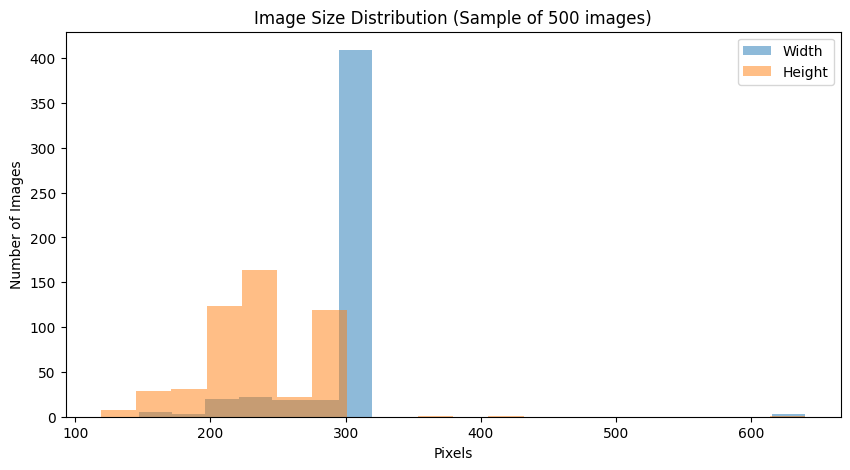

In [12]:
# Plot image size distribution
widths, heights = zip(*image_sizes)
plt.figure(figsize=(10, 5))
plt.hist(widths, bins=20, alpha=0.5, label="Width")
plt.hist(heights, bins=20, alpha=0.5, label="Height")
plt.xlabel("Pixels")
plt.ylabel("Number of Images")
plt.title("Image Size Distribution (Sample of 500 images)")
plt.legend()
plt.show()

In [14]:
print(f"Mean width: {np.mean(widths)}, Std dev: {np.std(widths)}")
print(f"Mean height: {np.mean(heights)}, Std dev: {np.std(heights)}")

Mean width: 290.776, Std dev: 39.26389975537325
Mean height: 234.432, Std dev: 47.73980913242113


In [15]:
unique_sizes = set(image_sizes)
print(f"Unique image sizes (sample): {list(unique_sizes)[:10]}")

Unique image sizes (sample): [(300, 270), (256, 300), (300, 215), (221, 300), (284, 219), (300, 279), (243, 300), (640, 640), (179, 300), (288, 216)]


In [16]:
target_size = (224, 224)

def resize_image(img_path):
    img = Image.open(img_path)
    img = img.resize(target_size)
    return img

ANALYSIS text-animals

In [ ]:
# Load dataset
data_path2 = "data/trans/text-animals.csv"
df = pd.read_csv(data_path2)

In [22]:
print(df.head())

                                       text label
0     I saw a dog running across the field.   dog
1        The dog barked at the passing car.   dog
2       My neighbor's dog is very friendly.   dog
3  We adopted a dog from the local shelter.   dog
4          The dog wagged its tail happily.   dog


In [23]:
print(f"Total samples: {len(df)}")
print(f"Unique labels: {df['label'].unique()}")
print(f"Missing values:\n{df.isnull().sum()}")

Total samples: 1000
Unique labels: ['dog' 'horse' 'elephant' 'butterfly' 'chicken' 'cat' 'cow' 'sheep'
 'squirrel' 'spider']
Missing values:
text     0
label    0
dtype: int64


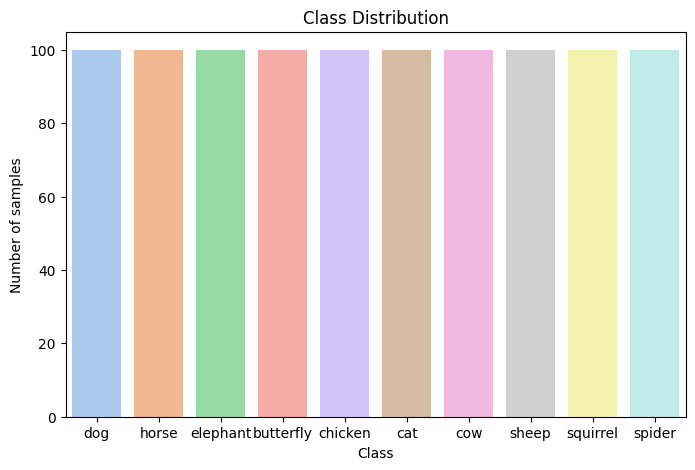

In [24]:
# Class distribution
class_counts = df["label"].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="pastel")
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.title("Class Distribution")
plt.show()

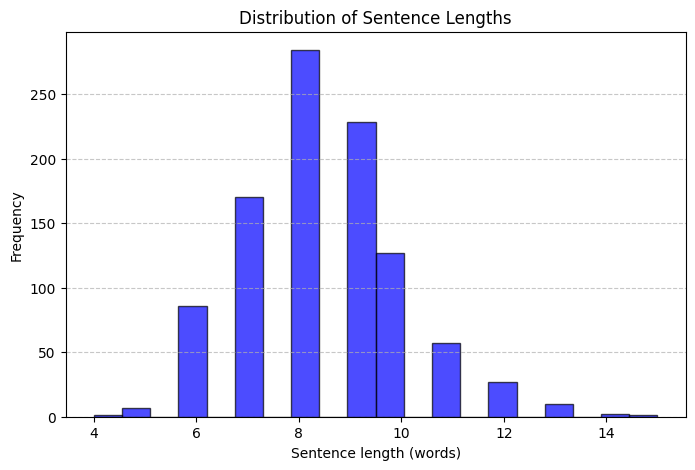

In [26]:
# Histogram of sentence length using Matplotlib
plt.figure(figsize=(8, 5))
plt.hist(df["text_length"], bins=20, color="blue", alpha=0.7, edgecolor="black")
plt.xlabel("Sentence length (words)")
plt.ylabel("Frequency")
plt.title("Distribution of Sentence Lengths")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [27]:
# Word frequency analysis (excluding stop words)
all_words = " ".join(df["text"]).lower().split()
word_counts = Counter(all_words)

In [28]:
# Top 10 most common words
most_common_words = word_counts.most_common(10)
print("Top 10 most common words:", most_common_words)

Top 10 most common words: [('the', 903), ('a', 518), ('he', 193), ('to', 187), ('she', 185), ('we', 154), ('in', 123), ('on', 94), ('its', 92), ('dog', 88)]


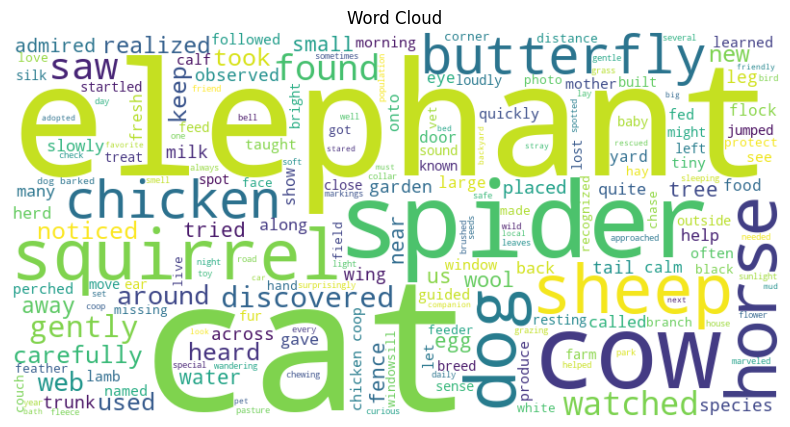

In [29]:
# Word cloud visualization
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(df["text"]))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud")
plt.show()

In [30]:
# Check for duplicate sentences
duplicates = df.duplicated(subset=["text"]).sum()
print(f"Number of duplicate sentences: {duplicates}")

Number of duplicate sentences: 0
